# Spin Chain Replication

## 1. Problem specification

The sample is a one-dimensional spin chain with dimensions: 
- length $l_{x} = 60\text{nm}$,
- width $l_{y} = 4\text{nm}$, and
- depth $l_{z} = 4\text{nm}$.

The material parameters are YIG-like:
- exchange energy constant, A = $1.6\times10^{-11}\text{J/m}$,
- saturation magnetisation, $M_{s} = 800\text{kA/m}$,
- Dzyaloshinskii-Moriya interaction constant, $D = 1.5\text{mJ/m}^{2}$,
- Gilbert damping, $\alpha = 1\times10^{-4}$, and
- gyromagnetic ratio, $\gamma = 29.2 \text{GHz/rad T}$.

The magnetisation dynamics are governed by the Landau-Lifshitz-Gilbert equation:
\begin{equation}
\frac{d\mathbf{m}}{dt} = -\gamma_{0} (\mathbf{m} \times \mathbf{H}_{\text{eff}}) + \alpha (\mathbf{m} \times \frac{d\mathbf{m}}{dt}),
\end{equation}
where $\gamma_{0} = \gamma \mu_{0}$, $\mu_{0}$ is the magnetic constant, and $\mathbf{H}_{\text{eff}}$ is the effective field.

The effective field is given by:
\begin{equation}
\mathbf{H}_{\text{eff}} = -\frac{1}{\mu_{0} M_{s}} \frac{\delta W}{\delta \mathbf{m}},
\end{equation}
where $W$ is the total energy of the system.

In this problem, the system is set at a known magnetisation state which is assumed to be an equilibrium state. The system is then perturbed by a time-dependent Zeeman magnetic field $h_{x,t}$ in the $\hat{x}$ direction. The boundaries of the problem are handled by fixing the magnetisation of the first and last spins in the chain.


## 2. Python setup

### 2.1. General Tools

Once a cell has been run any defined variables are stored in memory and can be accessed by any other cell. This is useful for defining constants, functions, and other objects that are used throughout the notebook. However, it may be desirable to clear all variables from memory and start from scratch. This can be done by running the following cell:

In [13]:
%reset -f

### 2.2. Python setup

#### 2.2.1. Common Python modules

Place common Python modules here.

In [14]:
import matplotlib.pyplot as plt
import numpy as np

#### 2.2.2. Ubermag modules

Place Ubermag modules here.

In [15]:
import discretisedfield as df
import micromagneticmodel as mm
import micromagneticdata as md

#### 2.2.3. Ubermag calculators

Place Ubermag calculators here.

In [16]:
import oommfc as oc

In [17]:
# OOMMF test: Check if the runner is active
# oc.runner.runner.status  

#### 2.2.4. Other modules

In [18]:
from include.custom_helper_files.custom_system_properties import SystemProperties, SubRegion, MyRegions

## (Aside) Simulation parameters

Normally there would be a section here, of code, that would allow the user to input parameters for the simulation. However, for the purposes of this notebook, we will hard-code the parameters into the notebook as the are required.

## 3. Define our system (spin chain)

Each micromagnetic simulation is construed as a model which a micromagnetic calculator is then able to interpret and simulate. In Übermag each model is uniquely represented as a container called `mm.System`. In order to populate the container we need to provide (straight from the documentation) the:

1. energy equation;
2. dynamics equation
3. state of initial magnetisation (the "field")
4. temperature of the system;
5. name of the system.

With Ubermag there is a 'chicken-and-egg' with mesh definitions, and the first three items on our list. It is entirely possible to define a mesh *between* #2 and #3. Doing this keeps the mesh information close to the `system.m = df.Field()` statement which is useful when the key changes between simulation run are to do with differences in *spatial* dimensions and initial magnetisations states. I find this to be less readable, and it often requires defining the same properties in your own local variables instead of directly in Ubermag objects.

The other option is to define the mesh *before* #1. This separates the mesh from `system.m = df.Field()`, and works best when the spatial properties of the system are constant across multiple simulations. The advantage of this approach is that subregions, like two driving regions and a propagation region, can be provided an internal Ubermag mesh-name which you can pass to your energy/dynamics equations as well as your spatially- and/or time-dependent fields.

We'll be taking the latter approach. So, in this section we will work through each `mm.System` parameter in turn.

Note: The name of the system, and all other `name` `**kwargs` for that matter, must not container underscores `_` as this leads to errors within the Übermag framework.

### 3.1. System name

In [19]:
system_spinchain = mm.System(name='PrimarySpinchain')

### 3.2. Mesh configuration

#### 3.2.1. Main region

[Documentation page](https://ubermag.github.io/api/_autosummary/discretisedfield.Region.html#discretisedfield.Region).

Each mesh (seen in §3.2.2) requires is composed of at least one region; implicitly through default actions or explicitly as we shall do here in §3.4.1. If a simple system only has a single region then it is common to define the region (and mesh) alongside handling the energy, dynamics, and magnetisation field components, in a single code block.

Note: I disliked how Ubermag handled storing these value, so I created my own dataclass `SystemProperties` to store these values.

In [24]:
# Geometry
spinchains_props = SystemProperties(lx=1002, ly=2, lz=2)

In Ubermag, all finite-difference methods can only be applied to cuboidal meshes. To define such a mesh all Ubermag requires are two diagonally opposite positions $p1$ and $p2$:

In [25]:
# Starting point, p1
spinchains_props.p1 = (0, 0, 0)

# End point, p2, which is diagonally opposite p1
spinchains_props.p2 = (spinchains_props.lx, spinchains_props.ly, spinchains_props.lz)

In [26]:
# Mesh discretisation cell size
spinchains_props.cell = (4e-9, 2e-9, 2e-9)  # (m, m, m)
spinchains_props.update_lengths()

# Number of discretised cells in each dimension
spinchains_props.update_numcells()

In [27]:
spinchains_props

SystemProperties(lx=4.008e-06, ly=4e-09, lz=4e-09, cell=(4e-09, 2e-09, 2e-09), p1=(0, 0, 0), units=('m', 'm', 'm'), p2=(4.008e-06, 4e-09, 4e-09), numcells=(1002, 2, 2))


We can now define the main region via the `df.Region` class`. Two optional parameters have been included:
- `dims` which is a list of the region's dimensions that are used for labelling on plots, and
- `units` which is a list of the region's units.

These default to `['x', 'y', 'z']` and `['m', 'm', 'm']` respectively for a 3D region. If a 2D region is used then the `dims` list should be `['x', 'y']` and the `units` list should be `['m', 'm']` *etc*.

In [28]:
spinchain_regions = MyRegions(system_spinchain.name)

In [34]:
spinchain_regions.region1(p1=spinchains_props.p1, p2=spinchains_props.p2, dims=('x', 'y', 'z'), units=('m', 'm', 'm'));

In [30]:
spinchain_regions.regions

{'region1': Region(pmin=[0.0, 0.0, 0.0], pmax=[4.008e-06, 4e-09, 4e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm'])}

#### 3.2.2. Subregions

[Example page](https://ubermag.github.io/examples/notebooks/fixed-subregions.html).

A region can be split into unique subdivisions called `subregions`. This approach greatly simplifies generating multilayer structures as one doesn't need to treat each layer as an independent entity or system; reducing boilerplate code. To create our subregions we define a dictionary of `df.Region` objects. 

I find it easiest to define the cell size first (which is required by `df.Mesh`) because this lets us scale subregions in a more intuitive manner by generating the number of cells in each dimension.

Note: Ensure that the subregions remain within the bounds of the parent region. This can be checked through the `df.Region.__contains__()` method.

For a 1D spin chain where the fixed subregions are at both ends of the spin chain and are one cell size in length, we can define the subregions by:
- by providing the `p1` and `p2` coordinates for each subregion, or
- by providing the `p2` coordinate for each subregion knowing that the `p1` coordinate is the coordinate of the preceding subregion.

I've done the latter here while using `system_props.cell` and `system_props.numcells` as required to ensure that all subregions span the entire $\hat{y}$ and $\hat{z}$ dimensions.

How Ubermag's examples encourage you to define subregions really bothers me as it leads to huge dictionaries that are hard to read and manage. I've created the classes below to make this slightly easier. You can't change subregions once a mesh is defined, so this is essentially my subregions container

In [31]:
spinchain_subregions = MyRegions(system_spinchain.name)

We can now define the subregions, ensuring that each subregion is within the bounds of the parent region and has a unique name.

In [43]:
%%capture
spinchain_subregions.fixedLhs(p1=(0, 0, 0), p2=(1, 2, 2), cellsize=spinchains_props.cell)
spinchain_subregions.driven(p1=(1, 0, 0), p2=(21, 2, 2), cellsize=spinchains_props.cell)
spinchain_subregions.free(p1=(21, 0, 0), p2=(1001, 2, 2), cellsize=spinchains_props.cell)
spinchain_subregions.fixedRhs(p1=(1001, 0, 0), p2=(1002, 2, 2), cellsize=spinchains_props.cell);

#### 3.2.3. Mesh

[Documentation page](https://ubermag.github.io/api/_autosummary/discretisedfield.Mesh.html#discretisedfield.Mesh).

Now that we have bounded a region in space we can discretise it. This results in a mesh which is defined by the `df.Mesh` class which requires a region and a cell size. The region can be generated internally by `df.Mesh` through the provision of the same `p1` and `p2` arguments as `df.Region`. However, it is best practice to define the region explicitly, as we have done in §3.4.1., to improve code readability and maintainability.

There are two mutually-exclusive ways to discretise a region and create a mesh:
- pass `n` to `df.Mesh` which is a tuple of the number of discretisation cells in each dimension, and
- pass `cell` to `df.Mesh` which is a tuple of the length of each discretisation cell in each dimension.

In [44]:
spinchain_mesh = df.Mesh(region=spinchain_regions.region1.region,
                         cell=spinchains_props.cell,
                         subregions=spinchain_subregions.regions)#,
                         #bc='x')

We can print out the mesh to check how many total cells have been discretised as this will impact the computational cost of the simulation. 

In [45]:
print(f'Spinchain mesh (Num. discretised cells)\n'
      f'----------------\n'
      f' - X: {spinchain_mesh.n[0]}\n'
      f' - Y: {spinchain_mesh.n[1]}\n'
      f' - Z: {spinchain_mesh.n[2]}\n'
      f'----------------\n'
      f' - Total: {len(spinchain_mesh)}\n')

Spinchain mesh (Num. discretised cells)
----------------
 - X: 1002
 - Y: 2
 - Z: 2
----------------
 - Total: 4008



It's also a good idea to plot the mesh to ensure that the discretisation has been done correctly - no subregions are overlapping and the full region is defined as intended.

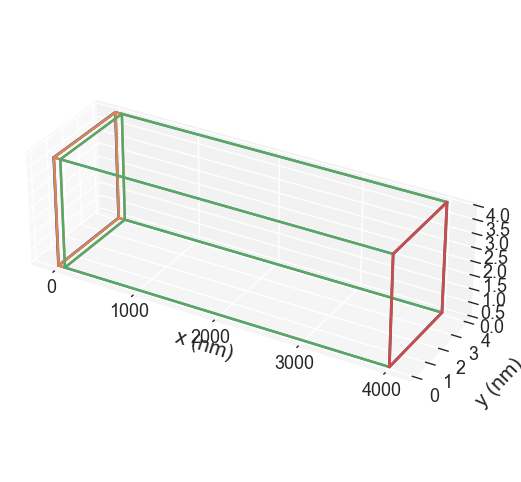

In [46]:
spinchain_mesh.mpl.subregions(multiplier=1e-9,box_aspect=(10, 3, 3), show_region=True)

### 3.3. Energy equation

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Energy.html#micromagneticmodel.Energy)

The *energy terms* can be stored either a container class `mm.Energy(terms=None)`, or directly in a system `mm.System.energy(terms=myEnergyTerms)`. Both container options are fundamentally composed of children and siblings that inherit their properties from the `mm.EnergyTerm(**kwargs)` [parent class](https://ubermag.github.io/api/_autosummary/micromagneticmodel.EnergyTerm.html#micromagneticmodel.EnergyTerm).

To build our energy equation we can:
1. define an empty list and append each term to the list through the `append` method.
2. define each `EnergyTerm` object and then combine them into a list: 
- `energy_terms = [term1, term2, term3]`.
- `energy_terms = term1 + term2 + term3`.

It's then a simple matter to do `system.energy = mm.Energy(terms=energy_terms)`.

Note: It is possible to initialise an empty variable with `energy_terms = None` and append to it through `+=`. However, the first term must be assigned to the variable, not appended. So this is method normally just adds boilerplate code.

In [ ]:
#spinchain_energy_terms = None

#### 3.2.1. Static zeeman energy

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Zeeman.html#micromagneticmodel.Zeeman). 

It's important to note that:
- This term covers both static, *i.e.* $\mathbf{H}_{0}$, and dynamic, *i.e.* $\mathbf{h}_{(x,t)}$, magnetic fields.
- If one wants to include more than one `mm.Zeeman()` in the same region then these Zeeman energies **must** be given different names.

In [47]:
# Align along the z-direction
spinchain_H0 = (0, 0, 0.1)  # (T) 

If our initial pumping field strength was given in $T$ then we need to convert to a tuple in the required units $A/m$.

In [48]:
spinchain_H0 = tuple([x/mm.consts.mu0 for x in spinchain_H0])  # (A/m)

We can now create the static Zeeman energy term, give it an appropriate name to uniquely identify it, and append to the region's `EnergyTerm` container. If we don't want to reuse `spinchain_Hext_static`, such as to print it or add it to another system, then we can simply append it to `system_spinchain.energy`.

Remember that the first term must be assigned, not appended.

In [ ]:
spinchain_zeeman_static = mm.Zeeman(H=spinchain_H0, 
                                    name='SpinchainZeemanStatic')

In [ ]:
system_spinchain.energy += spinchain_zeeman_static 

To avoid an odd behaviours, particularly with graphical outputs or text involving the Math environment, it is best to handle output in a separate cell to an assingment. This is because the output of the assignment is the object itself, and not the output of the object's `__repr__` method.

In [ ]:
# Print equation of Zeeman energy
# spinchain_zeeman_static

#### 3.3.2. Dynamic zeeman energy

See comments for Section 3.2.1.

There are two approaches on can take to apply this field. For clarity, I'll show both and denote which is actively being employed. Let's first define the constants we'll require.

In [ ]:
# Pumping field strength in the driven region
spinchain_h0 = (3e-3, 0, 0)  # (T)

# Driving (cut-off) frequency
spinchain_freq = 16e9  # (Hz)

# Time to adjust the phase (time shift) of a wave [t - t0]
spinchain_timeshift = 0  # (s)

# Time steps to evaluate at
stepsize = 1e-15  # (s)

In [ ]:
spinchain_h0 = tuple([x/mm.consts.mu0 for x in spinchain_h0])  # (A/m)

##### 3.3.2.1. Using pre-defined functions

If `mm_Zeeman()` is given a tuple for the `H` `kwarg` then the field is applied uniformly across the entire system; we utilised this behaviour in §3.3.1. to apply a static field. If we provide a dictionary to `H` then we can constrain our new `mm_Zeeman` to a specific subregion. All that remains is to introduce a time-dependence to this driven field, and Ubermag helps us out with some direct tools. This function 

In [ ]:
spinchain_zeeman_dynamic_dict = mm.Zeeman(H={spinchain_subregions_names[1]: spinchain_h0}, 
                                    name='SpinchainZeemanDynamic',
                                    func='sin',
                                    f=spinchain_freq,
                                    t0=spinchain_timeshift,
                                    dt=stepsize)


Here, we want our driving field, $\mathbf{h}_{(x, t)}$, to depend upon position (only applied in the driving region) and time (vary as the simulation progresses). To achieve this we'll need to write a custom callable function that will be used to define a `df.Field` object. Then we can pass this field object to `mm.Zeeman()`.

The only required argument of the callable function is `pos` which is a tuple of the position coordinates $(x, y, z)$. The function must return a tuple of the field components $(h_{x}, h_{y}, h_{z})$.

In [ ]:
def dynamic_zeeman_func(pos):
    # Unpack position
    x, y, z = pos
    
    # Should match dimensions given in mesh definition in §3.4.2.
    if x >= 5e-9 and x < 55e-9:
        # Return the time-dependent field
        return spinchain_h0
    else:
        # Return the base case (typically will just be zero outside the driven region)
        return (0, 0, 0)


Now we can create the dynamic Zeeman energy term, give it an appropriate name to uniquely identify it, and append to the region's `EnergyTerm` container. 

If the `name` `**kwargs` is not provided then an `EnergyTerm` is provided the `name` `**kwarg` then the default value is used. When a single `mm.System` has two or more `mm.EnergyTerm` with the same name value, including the default, then an error is thrown.

Notice that if we didn't use a `func` to define any oscillatory behaviour then we would return the *ZeemanStatic* case. 

In [ ]:
spinchain_zeeman_dynamic = mm.Zeeman(H={spinchain_subregions_names[1]: spinchain_h0}, 
                                    name='SpinchainZeemanDynamic',
                                    func='sin',
                                    f=spinchain_freq,
                                    t0=spinchain_timeshift,
                                    dt=stepsize)

In [ ]:
spinchain_h0_field = df.Field(mesh=spinchain_mesh,
                              nvdim=3,
                              value=dynamic_zeeman_func)

In [ ]:
spinchain_h0_field.sel('z').mpl()

In [ ]:
zee_dyn_test_energy = mm.Zeeman(H=spinchain_h0_field,
                                name='TestDynamicZeeman',
                                func='sin',
                                f=spinchain_freq,
                                t0=spinchain_timeshift,
                                dt=stepsize)

We don't want to immediately add this term to our energy equation, because it'll cause problems during the relaxation process. Once that is completed, then we'll then append this term to the energy equation.

In [ ]:
# Print equation of Zeeman energy
# spinchain_zeeman_dynamic

#### 3.2.3. (Heisenberg) Exchange energy

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Exchange.html#micromagneticmodel.Exchange).

Be cautious! Übermag requires that we provide an exchange interaction energy in $J/m$ and not in $T$ like we normally use!

In [ ]:
# Exchange interaction energy, A
spinchain_exch_energy_const = 1.6 * 1.3e-11  # (J/m)

# Alternative way to define A
# spinchain_exch_energy_const = 0.5 * mm.consts.mu0 * Ms**2 * lex**2

Similar to §3.2.2, we can create the exchange energy term, give it an appropriate name to uniquely identify it, and append to the region's `EnergyTerm` container.

In [ ]:
spinchain_exchange_energy = mm.Exchange(A=spinchain_exch_energy_const,
                                        name='SpinchainExchange')

In [ ]:
system_spinchain.energy += spinchain_exchange_energy

In [ ]:
# Print equation of Heisenberg exchange energy
# spinchain_exchange_energy

#### 3.2.4. Dzyaloshinskii-Moriya interaction energy

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.DMI.html#micromagneticmodel.DMI).

Ubermag added additional extensions to OOMMF enabling the use of the DM interaction in more generalised cases for both interfacial and bulk. Therefore, one must pass both a $D_{i,j}$ constant and a crystalographic classification (`crystalclass`) to `mm.DMI()`. The possible values for `crystalclass` are:
- `T` (transverse),
- `O` (longitudinal),
- `Cnv` (cyclical), and
- `D2d` (dihedral).

Both cyclical and dihedral also require the provision of the norm's direction through appending an underscore `_` and the cardinal direction, *e.g.* `Cnv_x`.

In [ ]:
# Crystalographic classification
spinchain_dmi_crystalclass = 'T'

# Microscopic DM interaction constant
spinchain_dmi_D = 0.4e-3  # (J/m^2)

In [ ]:
spinchain_dmi_energy = mm.DMI(D=spinchain_dmi_D, 
                              crystalclass=spinchain_dmi_crystalclass,
                              name='SpinchainDMI')

In [ ]:
# Append to EnergyTerm
system_spinchain.energy += spinchain_dmi_energy

In [ ]:
# Print equation of DM interaction energy term
# spinchain_dmi_energy

#### 3.2.5. Demagnetisation energy

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Demag.html#micromagneticmodel.Demag).

Unless there is an *asymptotic radius* to consider then this simply involves a method call. 

Note: Adding $\mathbf{H}_{demag}$ to a simulation greatly increases the computational cost per iteration of the numerical model, and consequentually the total (real-world) runtime!

In [ ]:
spinchain_demag_energy = mm.Demag(name='SpinchainDemag')

In [ ]:
# Append to EnergyTerm
# system_spinchain.energy += spinchain_demag_energy

In [ ]:
# Print equation of DM interaction energy term
# spinchain_demag_energy

#### 3.2.6. Hamiltonian

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Energy.html#micromagneticmodel.Energy).

If we collected the various energy terms in a separate container then we now need to assign this to the system's energy. If we used `system.energy += term` then we can skip this step.

In [ ]:
# Uncomment if needed
# system_spinchain.energy =  mm.Energy(terms=spinchain_energy_terms)

At this stage, we've defined our Hamiltonian! By invoking `system.energy` like a function we are able to utilise the `__repr__` method (provided by Übermag) to print out the Hamiltonian in a human-readable format.

In [ ]:
print(f'This energy equation has {len(system_spinchain.energy)} terms, and is given by the following equation')

# Print equation of system's energy terms
system_spinchain.energy

### 3.4. Dynamics equation

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Dynamics.html#micromagneticmodel.Dynamics).

The *dynamics terms* are defined in an identical way to the *energy terms*. They can also be stored in either a container class `mm.Dynamics(terms=None)`, or directly in a system `mm.System.dynamics(terms=myDynamicsTerms)`. Both container options are fundamentally composed of children and siblings that inherit their properties from the `mm.DynamicsTerm(**kwargs)` [parent class](https://ubermag.github.io/api/_autosummary/micromagneticmodel.DynamicsTerm.html#micromagneticmodel.DynamicsTerm).

In [ ]:
#spinchain_dynamics_terms = None

#### 3.3.1. Precession term

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Precession.html#micromagneticmodel.Precession).

In [ ]:
# Gyrotropic ratio (A*s/kg) i.e. (C/kg)
spinchain_gamma = 2 * np.pi * 29.2e9  # (rad*Hz/T)

# Gyromagnetic ratio
spinchain_gamma0 = spinchain_gamma * mm.consts.mu0  # (m/A*s)

In [ ]:
spinchain_dynamics_precession = mm.Precession(gamma0=mm.consts.gamma0,
                                     name='SpinchainPrecession')

In [ ]:
# First DynamicsTerm so we assign instead of append
system_spinchain.dynamics = spinchain_dynamics_precession

In [ ]:
# Print equation of the precession dynamics term
# spinchain_dynamics_precession

#### 3.3.2. Damping term

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Damping.html#micromagneticmodel.Damping).

In [ ]:
spinchain_gilbert_factor = 1e-4

In [ ]:
spinchain_dynamics_damping = mm.Damping(alpha=spinchain_gilbert_factor,
                                       name='SpinchainDamping')

In [ ]:
system_spinchain.dynamics += spinchain_dynamics_damping

In [17]:
# Print equation of the damping dynamics term
# spinchain_dynamics_damping

#### 3.3.3. Dynamics equation

[Documentation page](https://ubermag.github.io/api/_autosummary/micromagneticmodel.Dynamics.html#micromagneticmodel.Dynamics).

The dynamics equation is now complete! By invoking `system.dynamics` like a function we are able to utilise the `__repr__` method (provided by Übermag) to print out the dynamics equation in a human-readable format.

If we collected the various dynamics terms in a separate container then we now need to pass this to the system's dynamics argument. If we used `system.dynamics += term` then we can skip this step.

In [18]:
# Uncomment if needed
# system_spinchain.dynamics = mm.Dynamics(terms=spinchain_dynamics_terms)

In [19]:
print(f'This dynamics equation has {len(system_spinchain.dynamics)} terms, and is given by the following equation')

# Print out equation of system's dynamics terms
system_spinchain.dynamics

This dynamics equation has 0 terms, and is given by the following equation


Dynamics()

### 3.5. Magnetisation field

[Documentation page](https://ubermag.github.io/api/_autosummary/discretisedfield.Field.html#discretisedfield.Field).

We are now able to define the overall magnetisation field of the system. The field is defined by the `df.Field` class which requires a mesh, the number of vector dimensions, the initial value of the field, and the norm of the field (the saturisation magnetisation $M_{\text{S}}$. A field can be defined in a number of ways:
- as a constant value,
- as a function of space,
- as a function of time,
- as a function of both space and time, or
- as a function of space and a scalar value.

Note: There is lots of flexibility in how fields can be defined, so do read through the documentation given throughout S. 3.2.

#### 3.5.1. Initial state(s) of region(s)

In Ubermag the convention is to provide the initial magnetisation $\mathbf{\hat{m}}_{\text{0}}$ for a region(s) as a tuple of unit vectors *i.e.* $(0.25, 0.1, 1.0)$ for a mixed-state. The correct units are them found by providing the saturisation magnetisation $M_{S}$ as the `norm` argument to `df.Field`. This ensures that the reader can clearly and easily interpret the relative magnitudes (of the initial state) along each axis, and thus the orientation of each spin.

We first define any constants and then the initial magnetisation $\mathbf{\hat{m}}_{\text{0}}$.

In [20]:
# Saturisation magnetisation, Ms
spinchain_sat_mag  = 800e3  # (A/m)

# Number of vector dimensions
spinchain_num_dims = 3

In [21]:
# Initial magnetisation unit vectors
spinchain_field_m0 = (0, 0, 1)

# Associate initial m_init states with our subregion names
spinchain_field_subregions = {spinchain_subregions_names[0]: spinchain_field_m0,
                                spinchain_subregions_names[1]: spinchain_field_m0,
                                spinchain_subregions_names[2]: spinchain_field_m0,
                                spinchain_subregions_names[3]: spinchain_field_m0}

NameError: name 'spinchain_subregions_names' is not defined

#### 3.5.2. Subregion-specific fields

The last step before defining the system's magnetisation field is to define any custom fields in the subregions. In our case this means defining `spinchain_h0_field` as shown below.

In [22]:
spinchain_h0_field = df.Field(mesh=spinchain_mesh,
                              nvdim=3,
                              value=dynamic_zeeman_func)

NameError: name 'spinchain_mesh' is not defined

In [23]:
spinchain_h0_field.sel('z').mpl()

NameError: name 'spinchain_h0_field' is not defined

In [24]:
zee_dyn_test_energy = mm.Zeeman(H=spinchain_h0_field,
                                name='TestDynamicZeeman',
                                func='sin',
                                f=spinchain_freq,
                                t0=spinchain_timeshift,
                                dt=stepsize)

NameError: name 'spinchain_h0_field' is not defined

As a reminder, we don't want to include `spinchain_h0_field` in the system energy equation until after the relaxation.
 

#### 3.5.3.Defining the magnetisation field

We now define the system magnetisation field

In [25]:
system_spinchain.m = df.Field(mesh=spinchain_mesh, 
                              nvdim=spinchain_num_dims, 
                              value=spinchain_field_subregions,
                              norm=spinchain_sat_mag)

NameError: name 'spinchain_mesh' is not defined

This is a good time to check the field to ensure that the initial magnetisation has been defined correctly.

In [26]:
%%capture
spinchain_field_fig, (spinchain_field_ax1, spinchain_field_ax2, spinchain_field_ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 8));
spinchain_field_fig.suptitle('Initial magnetisation fields', fontsize=24)

system_spinchain.m.sel('x').mpl(ax=spinchain_field_ax1);

system_spinchain.m.sel('y').mpl(ax=spinchain_field_ax2);
spinchain_field_ax2.set(aspect=40)
system_spinchain.m.sel('z').mpl(ax=spinchain_field_ax3);

spinchain_field_fig.tight_layout()

AttributeError: 'NoneType' object has no attribute 'sel'

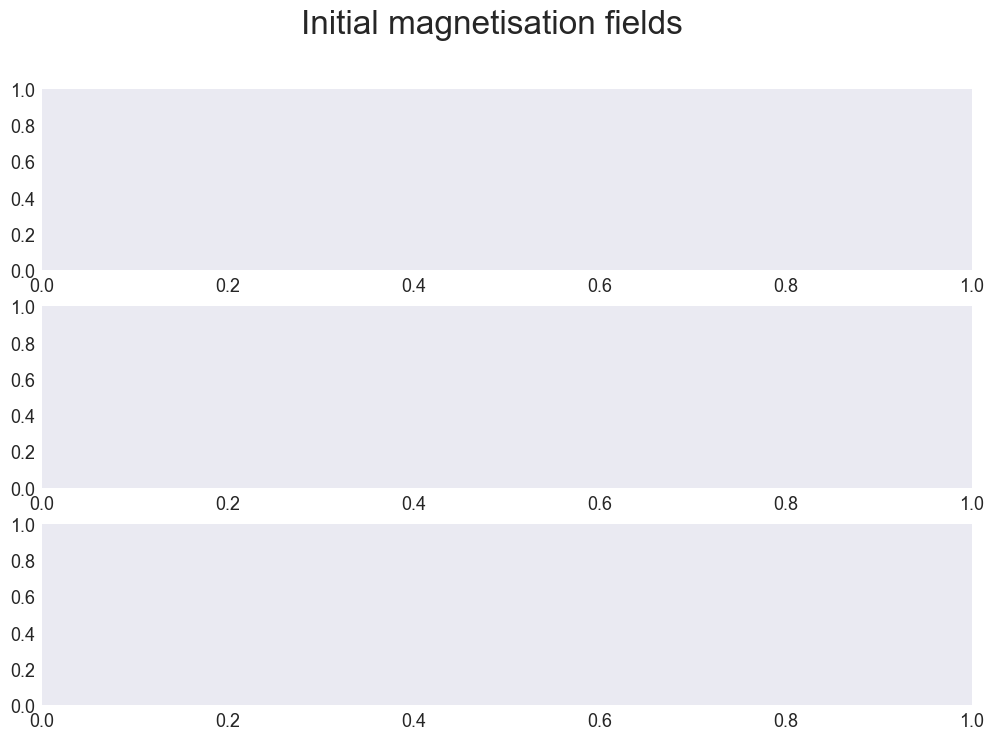

In [27]:
spinchain_field_fig

## 4. Simulation

We'll now begin our simulation stages!

### 4.1. Step 1: minimise energy

The first step is to minimise the energy of the system and find an equilibrium state. Once this is achieved we can procede to our time-dependent drivers. If the system has been initialised in an equilibrium state then this step can be skipped.

#### 4.1.1. Create driver

[Übermag documentation: MinDriver()](https://ubermag.github.io/api/_autosummary/oommfc.MinDriver.html#oommfc.MinDriver)

This energy minimisation driver we will use, `MinDriver`, is an implementation of the OOMMF `Oxs_MinDriver` driver. It is used to minimise the energy of the system and find an equilibrium state. The driver is based on the conjugate gradient method. The allowed parameters come from the [OOMMF v2.0 Userguide 2020 (pp.89-90): Oxs_MinDriver](https://math.nist.gov/oommf/doc/userguide20b0/userguide.pdf). 


In [28]:
sim_stage1_mindriver = oc.MinDriver() 

#### 4.1.2. Run driver

Übermag has made several adaptations to try and simplify the process of passing parameters to drivers. These parameters will therefore not be found in the OOMMF documentation, but they can be found here in the [Übermag documentation of the parent class (oommfc.Driver()](https://ubermag.github.io/api/_autosummary/oommfc.Driver.html#oommfc.Driver). Some examples include:
- `n_threads` which is the number of threads to use for the calculation, and
- `fixed_subregions` which is a dictionary of the fixed subregions in the mesh.

After setting the driver's arguments we can now call the driver. This will begin the simulation as shown by the progressbar (activately via `verbose=2` below this notebook cell. You'll know that the simulation is complete when a time popus up *e.g.* Running OOMMF (ExeOOMMFRunner) \[YYYY/MM/DD HH:MM]...(0.8 s).

Note: It's important that we don't include any time-dependent contributions to `system.energy` while running an `oommfc.MinDriver()` as this will lead to an error.

In [29]:
sim_stage1_mindriver.drive(system_spinchain,
                           fixed_subregions=[spinchain_subregions_names[0], spinchain_subregions_names[3]],
                           verbose=2)

NameError: name 'spinchain_subregions_names' is not defined

#### 4.1.3. Check output

##### 4.1.3.1 Vector plot with colour bar

AttributeError: 'NoneType' object has no attribute 'sel'

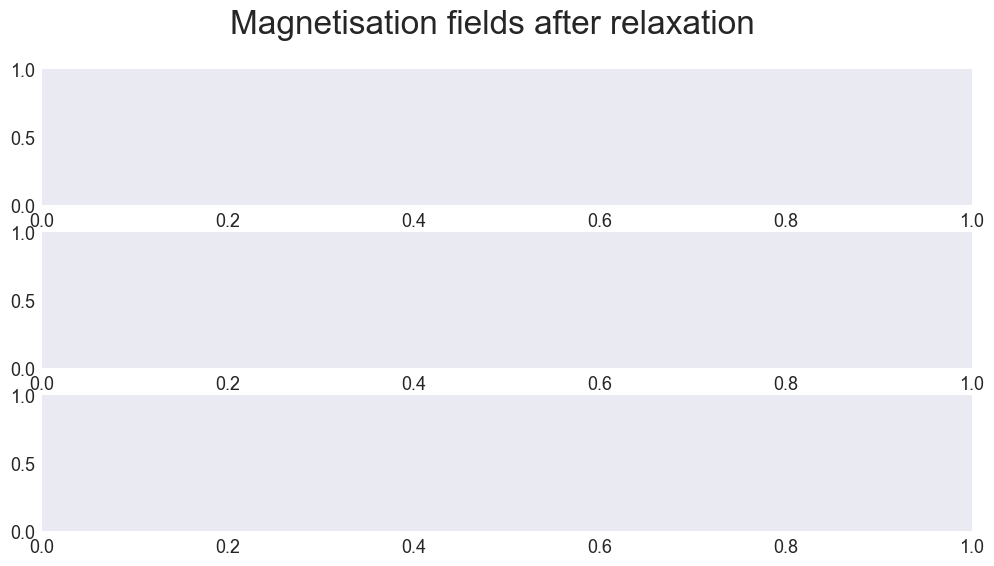

In [30]:
sim_stage1_fig, (sim_stage1_ax1, sim_stage1_ax2, sim_stage1_ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12,6))
sim_stage1_fig.suptitle('Magnetisation fields after relaxation', fontsize=24)
system_spinchain.m.sel('x').mpl(ax=sim_stage1_ax1);


system_spinchain.m.sel('y').mpl(ax=sim_stage1_ax2);
sim_stage1_ax2.set(aspect=40)

system_spinchain.m.sel('z').mpl(ax=sim_stage1_ax3);

sim_stage1_fig.tight_layout()

##### 4.1.4. Line plot

We can see..

In [31]:
sim_stage1_line = system_spinchain.m.line(p1=system_spinchain.m.mesh.region.pmin,
                               p2=system_spinchain.m.mesh.region.pmax, n=100)
#sim_stage1_line.mpl(marker='o', markersize=0)
sim_stage1_line.mpl(figsize=(4, 4))

AttributeError: 'NoneType' object has no attribute 'line'

### 4.2. Step 2: apply dynamic drive

The second step of the simulation is applying our dynamic drive, $\mathbf{h}_{(x, t)}$ to the system. This is done by creating a `TimeDriver` object and passing it to the system.

#### 4.2.1. Update energy equation

First we add the dynamic Zeeman term to the energy equation.

In [32]:
system_spinchain.energy += zee_dyn_test_energy

NameError: name 'zee_dyn_test_energy' is not defined

In [33]:
system_spinchain.energy

Energy()

#### 4.2.2. Create driver (TimeDriver)

[Übermag documentation: TimeDriver()](https://ubermag.github.io/api/_autosummary/oommfc.TimeDriver.html#oommfc.TimeDriver).

The `TimeDriver` object is an implementation of the OOMMF `Oxs_TimeDriver` driver. It is used to drive the system in time and solve the Landau-Lifshitz-Gilbert equation. The driver is based on the Runge-Kutta-Fehlberg method. The allowed parameters come from the [OOMMF v2.0 Userguide 2020 (pp.89-90): Oxs_TimeDriver](https://math.nist.gov/oommf/doc/userguide20b0/userguide.pdf).

You might have noticed in §4.1.2. that we didn't specify a stepsize for `oommfc.MinDriver()` or even a numerical method.This is because `oommfc.TimeDriver` objects (of which `MinDriver() is a specialised subclass) are high-level interfaces. They abstract away most details in favour of providing an easy-to-use interface for setting up and running simulations.

We want more control over the simulation for this step, so we'll define which evolver, *i.e.* numerical method, to use when defining our `TimeDriver()`. The accepted single-purpose evolvers are:
- [Conjugate-gradient: CGEvolver()](https://ubermag.github.io/api/_autosummary/oommfc.CGEvolver.html#oommfc.CGEvolver),
- [Euler: EulerEvolver()](https://ubermag.github.io/api/_autosummary/oommfc.EulerEvolver.html#oommfc.EulerEvolver),
- [Heun: HeunEvolver()](https://ubermag.github.io/api/_autosummary/oommfc.HeunEvolver.html#oommfc.HeunEvolver),
- [Runge-Kutta: RungeKuttaEvolver()](https://ubermag.github.io/api/_autosummary/oommfc.RK23Evolver.html#oommfc.RK23Evolver),
- [Zhang-Li: SpinTEvolver()](https://ubermag.github.io/api/_autosummary/oommfc.ZhangLiEvolver.html#oommfc.ZhangLiEvolver), and
- [Slonczewski: SpinXferEvolver()](https://ubermag.github.io/api/_autosummary/oommfc.SpinXferEvolver.html#oommfc.SpinXferEvolver).

The possible Runge-Kutta evolvers are found here: [OOMMF v2.0 Userguide 2020 (p. 84): Oxs_RungeKuttaEvolver](https://math.nist.gov/oommf/doc/userguide20b0/userguide.pdf)

In [34]:
# Maximum simulated time
sim_stage_2_maxtime = 0.7e-9  # (s)

# number of steps during simulation
sim_stage_2_num_steps = 100

# Stepsize
sim_stage_2_stepsize = 1e-15  # (s)

print(f'Stepsize, h: {sim_stage_2_stepsize} (s)')

Stepsize, h: 1e-15 (s)


In [35]:
# oc.RungeKuttaEvolver._allowed_attributes

In [36]:
sim_stage2_evolver = oc.RungeKuttaEvolver(method='rk2',
                                          do_precess=1,
                                          allow_signed_gamma=0,
                                          min_timestep=sim_stage_2_stepsize, 
                                          max_timestep=sim_stage_2_stepsize,
                                          )

sim_stage2_timedriver = oc.TimeDriver(evolver=sim_stage2_evolver)

#### 4.2.3. Run driver

See comments for §4.1.2.

In [37]:
sim_stage2_timedriver.drive(system_spinchain, 
                            t=sim_stage_2_maxtime,
                            n=sim_stage_2_num_steps,
                            fixed_subregions=[spinchain_subregions_names[0], spinchain_subregions_names[3]],
                           verbose=2)

NameError: name 'spinchain_subregions_names' is not defined

#### 4.2.4. Outputs

##### 4.2.4.1. Vector graph

AttributeError: 'NoneType' object has no attribute 'x'

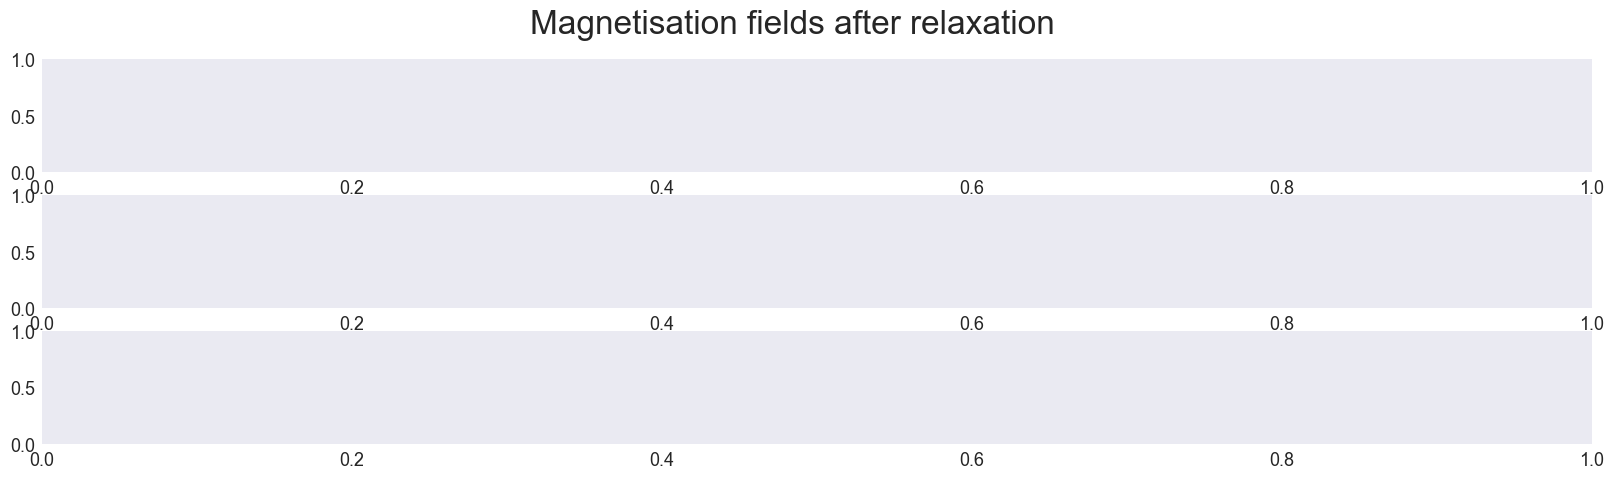

In [38]:
sim_stage2_fig, (sim_stage2_ax1, sim_stage2_ax2, sim_stage2_ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20, 5))
sim_stage2_fig.suptitle('Magnetisation fields after relaxation', fontsize=24)

# plot vectors on grid of 20 x 5 over the numerical resulotion
system_spinchain.m.x.sel('z').mpl(ax=sim_stage2_ax1)
sim_stage2_ax1.set(aspect=10)

# plot vectors on grid of 20 x 5 over the numerical resulotion
#system_spinchain.m.sel('z').resample(n=(80, 10)).mpl.vector(ax=sim_stage2_ax2)
#system_spinchain.m.x.sel('z').resample(n=(80, 5)).mpl.scalar(ax=sim_stage2_ax2, cmap='magma')#resample((80, 1)).mpl.vector(ax=sim_stage2_ax2)
#sim_stage2_ax2.set(aspect=10)
system_spinchain.m.y.sel('z').mpl(ax=sim_stage2_ax2)
sim_stage2_ax2.set(aspect=10)
# plot vectors on grid of 20 x 5 over the numerical resulotion
#system_spinchain.m.sel('z').resample(n=(80, 10)).mpl.vector(ax=sim_stage2_ax3)
#system_spinchain.m.y.sel('z').resample(n=(80, 5)).mpl.scalar(ax=sim_stage2_ax3, cmap='magma')
#sim_stage2_ax3.set(aspect=10)
# add colouring for mx-component to this plot
system_spinchain.m.sel('z').mpl(ax=sim_stage2_ax3)
sim_stage2_ax3.set(aspect=10)
#sim_stage2_ax3.set(aspect=100)

##### 4.2.4.2. Line plot

In [39]:
sim_stage2_line = system_spinchain.m.x.line(p1=system_spinchain.m.mesh.region.pmin,
                               p2=system_spinchain.m.mesh.region.pmax, n=100)
#sim_stage1_line.mpl(marker='o', markersize=0)
sim_stage2_line.mpl(figsize=(4, 4))

AttributeError: 'NoneType' object has no attribute 'x'

##### 4.2.4.3. Plot from table data

In [40]:
system_spinchain.table.data #

AttributeError: 'System' object has no attribute 'table'

In [41]:
system_spinchain.table.mpl(x='t',y=['mx','my'])

AttributeError: 'System' object has no attribute 'table'

In [42]:
# Extract magnetization components along the x-axis  # Extract x-coordinates
m_x = system_spinchain.m.array[:,0,0,0]  # Extract m_x component

AttributeError: 'NoneType' object has no attribute 'array'

In [43]:
m_x[0]

NameError: name 'm_x' is not defined

NameError: name 'm_x' is not defined

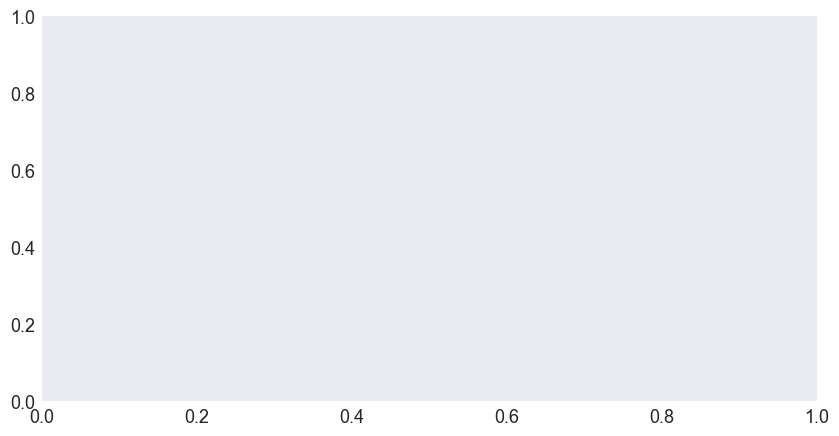

In [44]:
# Plot the magnetization components along the x-axis
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(0, 1002, 1) * 1e-9, m_x, label='m_x')

In [45]:
import os

In [46]:
dirname = os.path.join("../../tests", "PrimarySpinchain")
all_drives = md.Data(name='PrimarySpinchain', dirname='./')
current_drive = all_drives[50]
position_index = 100
axis_index = 0

In [47]:
sel_vals = [frame.array[position_index, 0, 0, axis_index] for frame in current_drive]

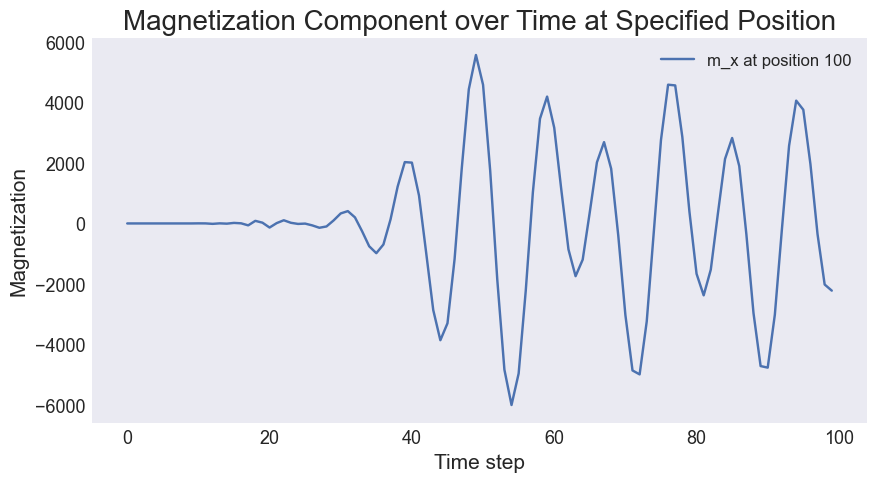

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(sel_vals)), sel_vals, label=f'm_{["x", "y", "z"][axis_index]} at position {position_index}')
plt.xlabel('Time step')
plt.ylabel('Magnetization')
plt.title('Magnetization Component over Time at Specified Position')
plt.legend()
plt.show()